# Import Library

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import os
import re

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'pandas'

In [19]:
# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# PENGUMPULAN DATA

In [21]:
print("Loading dataset...")
try:
    # Ganti path ini sesuai dengan lokasi file Anda
    chess = pd.read_csv("https://drive.google.com/uc?id=1gqGpIP4S5K8OsTCpCrzrdEw_dbw2oDX8")
    # Remove duplicates based on id
    chess = chess.drop_duplicates(subset=['id'])

    # Extract opening archetype dan opening moves
    chess = chess.assign(
        opening_archetype=chess.opening_name.map(
            lambda n: n.split(":")[0].split("|")[0].split("#")[0].strip()
        ),
        opening_moves=chess.apply(lambda srs: ' '.join(srs['moves'].split(" ")[:srs['opening_ply']]),
                              axis=1)
    )

    print(f"Dataset loaded successfully: {len(chess)} games")
    print(f"Number of unique openings: {len(chess.opening_name.unique())}")
    print(f"Number of unique players: {len(set(chess.white_id.unique()).union(set(chess.black_id.unique())))}")

except Exception as e:
    print(f"Error loading data: {e}")
    raise

# Tampilkan beberapa data awal untuk memahami struktur dataset
print("\nData sample:")
display(chess.head())

Loading dataset...
Dataset loaded successfully: 19113 games
Number of unique openings: 1477
Number of unique players: 15635

Data sample:


,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,opening_archetype,opening_moves
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,Slav Defense,d4 d5 c4 c6 cxd5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,Nimzowitsch Defense,d4 Nc6 e4 e5
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,King's Pawn Game,e4 e5 d3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,Queen's Pawn Game,d4 d5 Nf3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,Philidor Defense,e4 e5 Nf3 d6 d4


In [22]:
# Tampilkan informasi kolom
print("\nDataset info:")
chess.info()



Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 19113 entries, 0 to 20057
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 19113 non-null  object 
 1   rated              19113 non-null  bool   
 2   created_at         19113 non-null  float64
 3   last_move_at       19113 non-null  float64
 4   turns              19113 non-null  int64  
 5   victory_status     19113 non-null  object 
 6   winner             19113 non-null  object 
 7   increment_code     19113 non-null  object 
 8   white_id           19113 non-null  object 
 9   white_rating       19113 non-null  int64  
 10  black_id           19113 non-null  object 
 11  black_rating       19113 non-null  int64  
 12  moves              19113 non-null  object 
 13  opening_eco        19113 non-null  object 
 14  opening_name       19113 non-null  object 
 15  opening_ply        19113 non-null  int64  
 16  opening_arch

# Exploratory Data Analysis


Exploratory Data Analysis:


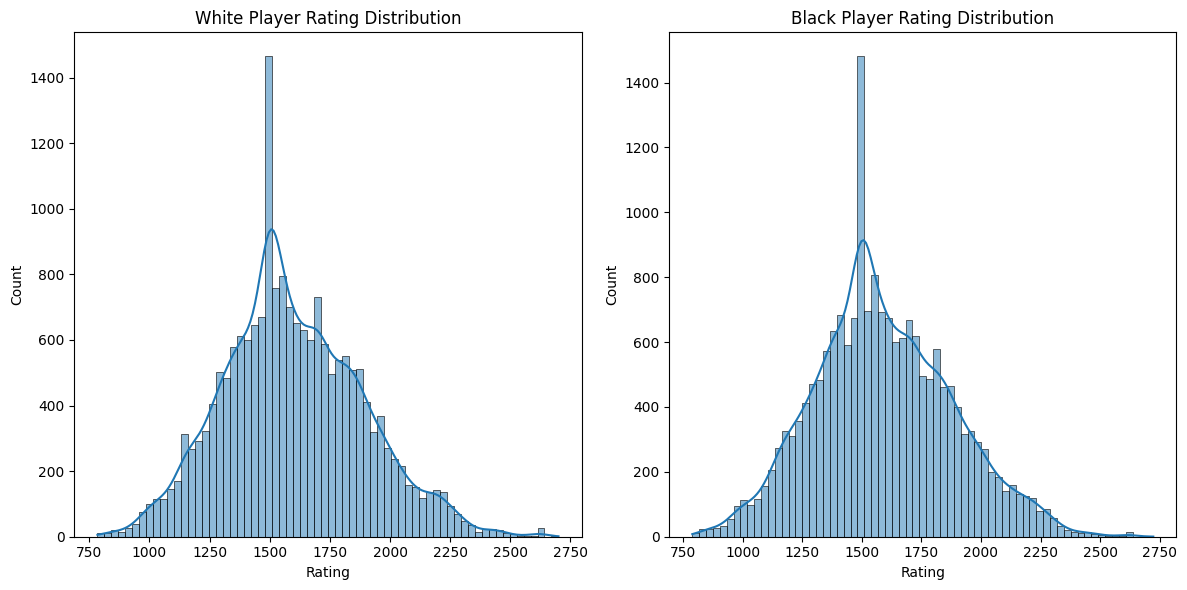

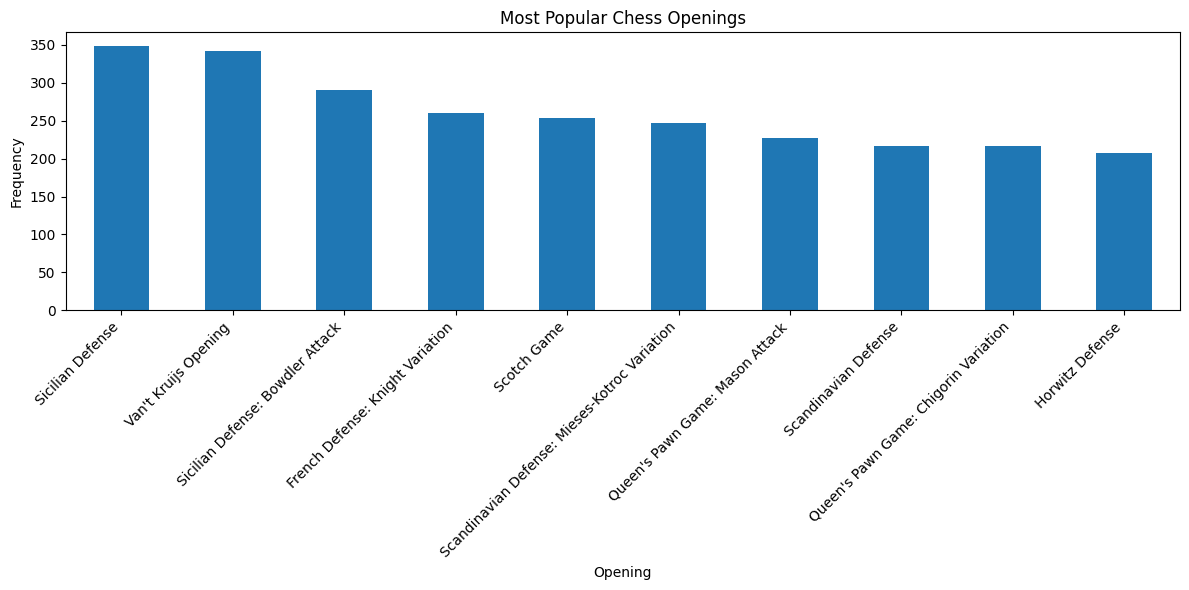

In [23]:
print("\nExploratory Data Analysis:")

# Distribusi rating pemain
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(chess['white_rating'], kde=True)
plt.title('White Player Rating Distribution')
plt.xlabel('Rating')

plt.subplot(1, 2, 2)
sns.histplot(chess['black_rating'], kde=True)
plt.title('Black Player Rating Distribution')
plt.xlabel('Rating')
plt.tight_layout()
plt.show()

# Top 10 Opening berdasarkan popularitas
plt.figure(figsize=(12, 6))
chess['opening_name'].value_counts().head(10).plot(kind='bar')
plt.title('Most Popular Chess Openings')
plt.xlabel('Opening')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Content-Based Filtering Model

In [24]:
print("\nTraining Content-Based Filtering Model...")

# Function untuk menghitung similarity berdasarkan sekuens gerakan pembukaan
def train_content_based_model(chess_data):
    """
    Melatih model Content-Based Filtering berdasarkan sekuens gerakan pembukaan catur
    """
    # Ekstrak semua nama pembukaan unik dan sekuens gerakan-nya
    opening_moves = {}
    for opening in chess_data.opening_name.unique():
        moves = chess_data[chess_data.opening_name == opening]['opening_moves'].values
        if len(moves) > 0:
            opening_moves[opening] = moves[0]
        else:
            opening_moves[opening] = ""

    # Buat TF-IDF Vectorizer untuk sekuens gerakan
    tfidf = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))

    # Fit TF-IDF pada semua sekuens gerakan
    all_moves = list(opening_moves.values())
    tfidf_matrix = tfidf.fit_transform(all_moves)

    # Hitung similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Buat DataFrame untuk similarity matrix
    opening_names = list(opening_moves.keys())
    similarity_df = pd.DataFrame(similarity_matrix, index=opening_names, columns=opening_names)

    # Simpan model dan data terkait
    content_based_model = {
        'tfidf_vectorizer': tfidf,
        'tfidf_matrix': tfidf_matrix,
        'opening_names': opening_names,
        'opening_moves': opening_moves,
        'similarity_matrix': similarity_df
    }

    # Simpan model ke file
    with open('content_based_model.pkl', 'wb') as f:
        pickle.dump(content_based_model, f)

    print("Content-Based Model saved to 'content_based_model.pkl'")
    return content_based_model

# Function untuk mendapatkan rekomendasi dari model content-based
def get_content_based_recommendations(favorite_openings, content_based_model, top_n=5):
    """
    Mendapatkan rekomendasi berdasarkan opening favorit dengan model content-based
    """
    similarity_df = content_based_model['similarity_matrix']
    opening_names = content_based_model['opening_names']

    # Filter rekomendasi hanya untuk opening yang ada dalam dataset
    valid_favorites = [opening for opening in favorite_openings if opening in opening_names]

    if not valid_favorites:
        return pd.DataFrame(columns=['opening_name', 'similarity_score'])

    # Hitung rata-rata similarity scores untuk semua opening favorit
    similarity_scores = similarity_df[valid_favorites].mean(axis=1)

    # Buat DataFrame rekomendasi
    recommendations = pd.DataFrame({
        'opening_name': similarity_scores.index,
        'similarity_score': similarity_scores.values
    })

    # Filter out favorite openings
    recommendations = recommendations[~recommendations.opening_name.isin(favorite_openings)]

    # Sort berdasarkan similarity score
    recommendations = recommendations.sort_values('similarity_score', ascending=False)

    return recommendations.head(top_n)

# Latih model Content-Based Filtering
content_based_model = train_content_based_model(chess)

# Test model dengan beberapa opening favorit
test_favorites = [chess.opening_name.iloc[0], chess.opening_name.iloc[10], chess.opening_name.iloc[20]]
print(f"\nTest Content-Based recommendations untuk opening favorit: {test_favorites}")
cb_recommendations = get_content_based_recommendations(test_favorites, content_based_model)
display(cb_recommendations)


Training Content-Based Filtering Model...
Content-Based Model saved to 'content_based_model.pkl'

Test Content-Based recommendations untuk opening favorit: ['Slav Defense: Exchange Variation', "Van't Kruijs Opening", 'Italian Game: Anti-Fried Liver Defense']


,opening_name,similarity_score
1007,Slav Defense: Exchange Variation | Symmetrica...,0.271512
1154,Slav Defense: Quiet Variation,0.269449
1048,Slav Defense: Modern,0.267221
517,Queen's Gambit Refused: Chigorin Defense | La...,0.267071
403,Slav Defense: Exchange Variation | Schallopp ...,0.266139


# Collaborative Filtering Model


Training Collaborative Filtering Model...
Collaborative Filtering data saved to 'collaborative_data.pkl'
Training collaborative model with 15635 players and 1477 openings


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ player_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ opening_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_embedding    │ (None, 1, 50)     │    781,750 │ player_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ opening_embedding   │ (None, 1, 50)     │     73,850 │ opening_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 50)        │          0 │ player_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 50)        │          0 │ opening_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_bias         │ (None, 1, 1)      │     15,635 │ player_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ opening_bias        │ (None, 1, 1)      │      1,477 │ opening_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 1)         │          0 │ flatten_8[0][0],  │
│                     │                   │            │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 1)         │          0 │ player_bias[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 1)         │          0 │ opening_bias[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1)         │          0 │ dot_1[0][0],      │
│                     │                   │            │ flatten_10[0][0], │
│                     │                   │            │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1)         │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 872,712 (3.33 MB)

 Trainable params: 872,712 (3.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
425/425 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.2352 - mean_absolute_error: 0.4844 - val_loss: 0.1989 - val_mean_absolute_error: 0.4446
Epoch 2/5
425/425 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1832 - mean_absolute_error: 0.4258 - val_loss: 0.1533 - val_mean_absolute_error: 0.3859
Epoch 3/5
425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1228 - mean_absolute_error: 0.3418 - val_loss: 0.1112 - val_mean_absolute_error: 0.3151
Epoch 4/5
425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0668 - mean_absolute_error: 0.2385 - val_loss: 0.0878 - val_mean_absolute_error: 0.2657
Epoch 5/5
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0348 - mean_absolute_error: 0.1619 - val_loss: 0.0758 - val_mean_absolute_error: 0.2367


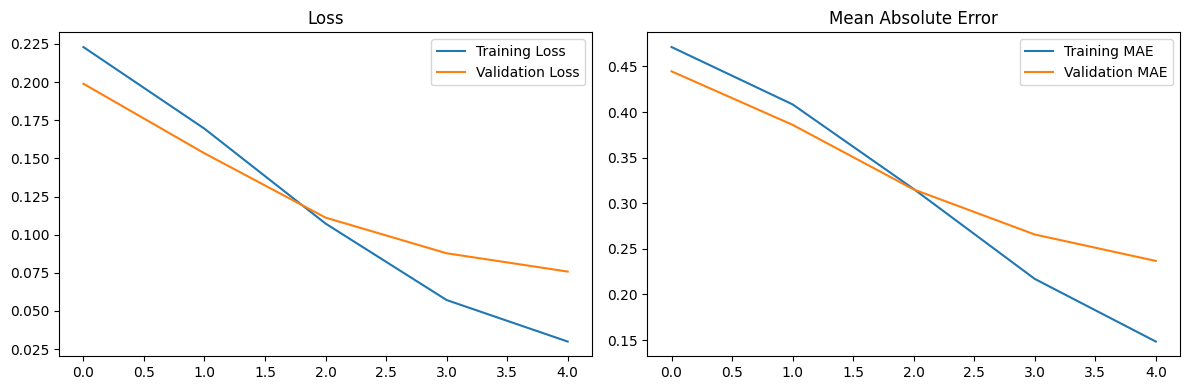

Collaborative Filtering model saved to 'collaborative_model' and 'collaborative_model_data.pkl'

Test Collaborative recommendations untuk rating: 1500


,opening_name,score
621,King's Indian Defense: Orthodox Variation | U...,0.485101
603,King's Indian Defense: Fianchetto Variation | ...,0.485033
1011,Rubinstein Opening,0.482296
58,Benoni Defense: Modern Variation | Snake Vari...,0.482089
906,Queen's Gambit Declined: Pseudo-Tarrasch Varia...,0.479105


In [27]:
print("\nTraining Collaborative Filtering Model...")

# Ekstrak data pemain dan opening
def prepare_collaborative_data(chess_data):
    """
    Menyiapkan data untuk Collaborative Filtering
    """
    # Ekstrak data pemain (baik sebagai white maupun black)
    player_white = chess_data[['white_id', 'opening_name', 'white_rating']].rename(
        columns={'white_id': 'player_id', 'white_rating': 'rating'})
    player_white['played_as'] = 'white'

    player_black = chess_data[['black_id', 'opening_name', 'black_rating']].rename(
        columns={'black_id': 'player_id', 'black_rating': 'rating'})
    player_black['played_as'] = 'black'

    # Gabungkan data pemain
    player_data = pd.concat([player_white, player_black])

    # Hitung frekuensi opening yang dimainkan oleh setiap pemain
    player_opening_matrix = player_data.groupby(['player_id', 'opening_name']).size().reset_index(name='frequency')

    # Label encoding untuk player_id dan opening_name
    player_encoder = LabelEncoder()
    opening_encoder = LabelEncoder()

    player_opening_matrix['player_encoded'] = player_encoder.fit_transform(player_opening_matrix['player_id'])
    player_opening_matrix['opening_encoded'] = opening_encoder.fit_transform(player_opening_matrix['opening_name'])

    # Hitung distribusi rating berdasarkan opening
    opening_rating = player_data.groupby('opening_name')['rating'].agg(['mean', 'median', 'std']).reset_index()

    # Simpan data preprocessing
    collaborative_data = {
        'player_encoder': player_encoder,
        'opening_encoder': opening_encoder,
        'player_opening_matrix': player_opening_matrix,
        'opening_rating': opening_rating,
        'player_data': player_data
    }

    # Simpan data ke file
    with open('collaborative_data.pkl', 'wb') as f:
        pickle.dump(collaborative_data, f)

    print("Collaborative Filtering data saved to 'collaborative_data.pkl'")
    return collaborative_data

# Latih Collaborative Filtering Model menggunakan Matrix Factorization berbasis Neural Network
def train_collaborative_model(collaborative_data, embedding_dim=50, epochs=20):
    """
    Melatih model Collaborative Filtering menggunakan Neural Network
    """
    # Data untuk pelatihan
    player_opening_matrix = collaborative_data['player_opening_matrix']

    # Tentukan jumlah player dan opening unik
    n_players = len(collaborative_data['player_encoder'].classes_)
    n_openings = len(collaborative_data['opening_encoder'].classes_)

    print(f"Training collaborative model with {n_players} players and {n_openings} openings")

    # Split data menjadi training dan validation
    train_data, val_data = train_test_split(
        player_opening_matrix[['player_encoded', 'opening_encoded', 'frequency']],
        test_size=0.2,
        random_state=42
    )

    # Normalisasi frequency untuk menjadi implicit rating (0-1)
    scaler = MinMaxScaler()
    train_data['rating'] = scaler.fit_transform(train_data[['frequency']])
    val_data['rating'] = scaler.transform(val_data[['frequency']])

    # Buat model Neural Network untuk Matrix Factorization
    player_input = keras.Input(shape=(1,), name='player_input')
    opening_input = keras.Input(shape=(1,), name='opening_input')

    # Embedding layer untuk player dan opening
    player_embedding = layers.Embedding(n_players, embedding_dim, input_length=1, name='player_embedding')(player_input)
    opening_embedding = layers.Embedding(n_openings, embedding_dim, input_length=1, name='opening_embedding')(opening_input)

    # Flatten embeddings
    player_flatten = layers.Flatten()(player_embedding)
    opening_flatten = layers.Flatten()(opening_embedding)

    # Dot product untuk mendapatkan rating
    dot_product = layers.Dot(axes=1)([player_flatten, opening_flatten])

    # Add bias
    player_bias = layers.Embedding(n_players, 1, input_length=1, name='player_bias')(player_input)
    opening_bias = layers.Embedding(n_openings, 1, input_length=1, name='opening_bias')(opening_input)

    player_bias_flatten = layers.Flatten()(player_bias)
    opening_bias_flatten = layers.Flatten()(opening_bias)

    # Combine all features
    add_layer = layers.Add()([dot_product, player_bias_flatten, opening_bias_flatten])

    # Sigmoid activation untuk mendapatkan output antara 0-1
    output = layers.Activation('sigmoid')(add_layer)

    # Buat model
    model = keras.Model(
        inputs=[player_input, opening_input],
        outputs=output
    )

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )

    # Print model summary
    model.summary()

    # Training
    history = model.fit(
        [train_data['player_encoded'], train_data['opening_encoded']],
        train_data['rating'],
        validation_data=(
            [val_data['player_encoded'], val_data['opening_encoded']],
            val_data['rating']
        ),
        epochs=epochs,
        batch_size=64,
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.legend()
    plt.title('Mean Absolute Error')
    plt.tight_layout()
    plt.show()

    # Ekstrak embedding matrices
    player_embedding_weights = model.get_layer('player_embedding').get_weights()[0]
    opening_embedding_weights = model.get_layer('opening_embedding').get_weights()[0]

    # Simpan model dan embedding matrices
    collaborative_model = {
        'model': model,
        'player_embedding': player_embedding_weights,
        'opening_embedding': opening_embedding_weights,
        'player_bias': model.get_layer('player_bias').get_weights()[0],
        'opening_bias': model.get_layer('opening_bias').get_weights()[0],
        'scaler': scaler
    }

    # Simpan model
    model.save('collaborative_model.keras')

    # Simpan data tambahan model
    with open('collaborative_model_data.pkl', 'wb') as f:
        pickle.dump({
            'player_embedding': player_embedding_weights,
            'opening_embedding': opening_embedding_weights,
            'player_bias': model.get_layer('player_bias').get_weights()[0],
            'opening_bias': model.get_layer('opening_bias').get_weights()[0],
            'scaler': scaler
        }, f)

    print("Collaborative Filtering model saved to 'collaborative_model' and 'collaborative_model_data.pkl'")
    return collaborative_model, history

# Function untuk mendapatkan rekomendasi openings berdasarkan rating pemain
def get_collaborative_recommendations(user_rating, collaborative_data, collaborative_model, top_n=5):
    """
    Mendapatkan rekomendasi opening berdasarkan rating pemain
    """
    # Cari pemain dengan rating yang mirip
    player_data = collaborative_data['player_data']
    rating_diff = abs(player_data['rating'] - user_rating)
    similar_players_idx = rating_diff.nsmallest(20).index
    similar_players = player_data.loc[similar_players_idx, 'player_id'].unique()

    # Jika tidak ada pemain yang mirip, return DataFrame kosong
    if len(similar_players) == 0:
        return pd.DataFrame(columns=['opening_name', 'score'])

    # Encode similar players
    player_encoder = collaborative_data['player_encoder']
    opening_encoder = collaborative_data['opening_encoder']

    # Filter similar players yang ada dalam encoder
    valid_similar_players = [p for p in similar_players if p in player_encoder.classes_]

    if len(valid_similar_players) == 0:
        return pd.DataFrame(columns=['opening_name', 'score'])

    # Encoded similar players
    encoded_similar_players = [player_encoder.transform([p])[0] for p in valid_similar_players]

    # Get all openings
    all_openings = opening_encoder.classes_
    encoded_all_openings = np.arange(len(all_openings))

    # Predict ratings for all openings for each similar player
    model = collaborative_model['model']

    # Initialize array for storing prediction scores
    all_predictions = np.zeros((len(valid_similar_players), len(all_openings)))

    # Make predictions
    for i, player_id in enumerate(encoded_similar_players):
        player_input = np.array([player_id] * len(all_openings))
        opening_input = encoded_all_openings

        predictions = model.predict(
            [player_input, opening_input],
            verbose=0
        )

        all_predictions[i, :] = predictions.flatten()

    # Average predictions across similar players
    avg_predictions = np.mean(all_predictions, axis=0)

    # Create recommendations DataFrame
    recommendations = pd.DataFrame({
        'opening_name': all_openings,
        'score': avg_predictions
    })

    # Sort by score
    recommendations = recommendations.sort_values('score', ascending=False)

    return recommendations.head(top_n)

# Siapkan data untuk Collaborative Filtering
collaborative_data = prepare_collaborative_data(chess)

# Latih model Collaborative Filtering
# Gunakan epochs yang lebih kecil untuk contoh (tingkatkan untuk model produksi)
collaborative_model, history = train_collaborative_model(collaborative_data, embedding_dim=50, epochs=5)

# Test model dengan rating pemain tertentu
test_rating = 1500
print(f"\nTest Collaborative recommendations untuk rating: {test_rating}")
cf_recommendations = get_collaborative_recommendations(test_rating, collaborative_data, collaborative_model)
display(cf_recommendations)


# Hybrid Filtering Model

In [28]:
print("\nDeveloping Hybrid Filtering Model...")

def get_hybrid_recommendations(favorite_openings, user_rating,
                               content_based_model, collaborative_data, collaborative_model,
                               alpha=0.7, top_n=5):
    """
    Mendapatkan rekomendasi hybrid filtering dengan menggabungkan content-based dan collaborative filtering

    Parameters:
    -----------
    favorite_openings : list
        List of favorite openings
    user_rating : int
        User's chess rating
    content_based_model : dict
        Content-based model
    collaborative_data : dict
        Collaborative filtering data
    collaborative_model : dict
        Collaborative filtering model
    alpha : float, default=0.7
        Weight for content-based recommendations (1-alpha for collaborative)
    top_n : int, default=5
        Number of recommendations to return

    Returns:
    --------
    pd.DataFrame
        Hybrid recommendations
    """
    # Get content-based recommendations
    content_recs = get_content_based_recommendations(favorite_openings, content_based_model, top_n=20)

    # Get collaborative filtering recommendations
    collab_recs = get_collaborative_recommendations(user_rating, collaborative_data, collaborative_model, top_n=20)

    # If either recommendation is empty, return the other
    if len(content_recs) == 0:
        return collab_recs.head(top_n)
    elif len(collab_recs) == 0:
        return content_recs.head(top_n)

    # Normalize scores if needed
    content_recs['cb_score'] = content_recs['similarity_score']
    collab_recs['cf_score'] = collab_recs['score']

    # Merge the recommendations
    hybrid_recs = pd.merge(content_recs, collab_recs, on='opening_name', how='outer')

    # Fill missing scores with 0
    hybrid_recs['cb_score'] = hybrid_recs['cb_score'].fillna(0)
    hybrid_recs['cf_score'] = hybrid_recs['cf_score'].fillna(0)

    # Calculate the hybrid score
    hybrid_recs['hybrid_score'] = alpha * hybrid_recs['cb_score'] + (1 - alpha) * hybrid_recs['cf_score']

    # Sort by hybrid score
    hybrid_recs = hybrid_recs.sort_values('hybrid_score', ascending=False)

    # Filter out the favorite openings
    hybrid_recs = hybrid_recs[~hybrid_recs.opening_name.isin(favorite_openings)]

    return hybrid_recs[['opening_name', 'hybrid_score', 'cb_score', 'cf_score']].head(top_n)

# Simpan function hybrid filtering ke dalam pickle
hybrid_model = {
    'get_hybrid_recommendations': get_hybrid_recommendations,
    'alpha': 0.7  # Default weight untuk content-based filtering
}

with open('hybrid_model.pkl', 'wb') as f:
    pickle.dump(hybrid_model, f)

print("Hybrid model saved to 'hybrid_model.pkl'")

# Test hybrid recommendations
test_rating = 1500
test_favorites = [chess.opening_name.iloc[0], chess.opening_name.iloc[10], chess.opening_name.iloc[20]]
print(f"\nTest Hybrid recommendations untuk rating: {test_rating} dan opening favorit: {test_favorites}")
hybrid_recs = get_hybrid_recommendations(
    test_favorites, test_rating,
    content_based_model, collaborative_data, collaborative_model
)
display(hybrid_recs)


Developing Hybrid Filtering Model...
Hybrid model saved to 'hybrid_model.pkl'

Test Hybrid recommendations untuk rating: 1500 dan opening favorit: ['Slav Defense: Exchange Variation', "Van't Kruijs Opening", 'Italian Game: Anti-Fried Liver Defense']


,opening_name,hybrid_score,cb_score,cf_score
35,Slav Defense: Exchange Variation | Symmetrica...,0.190059,0.271512,0.0
37,Slav Defense: Quiet Variation,0.188615,0.269449,0.0
36,Slav Defense: Modern,0.187055,0.267221,0.0
23,Queen's Gambit Refused: Chigorin Defense | La...,0.186950,0.267071,0.0
34,Slav Defense: Exchange Variation | Schallopp ...,0.186298,0.266139,0.0


# Evaluasi Model


Model Evaluation:


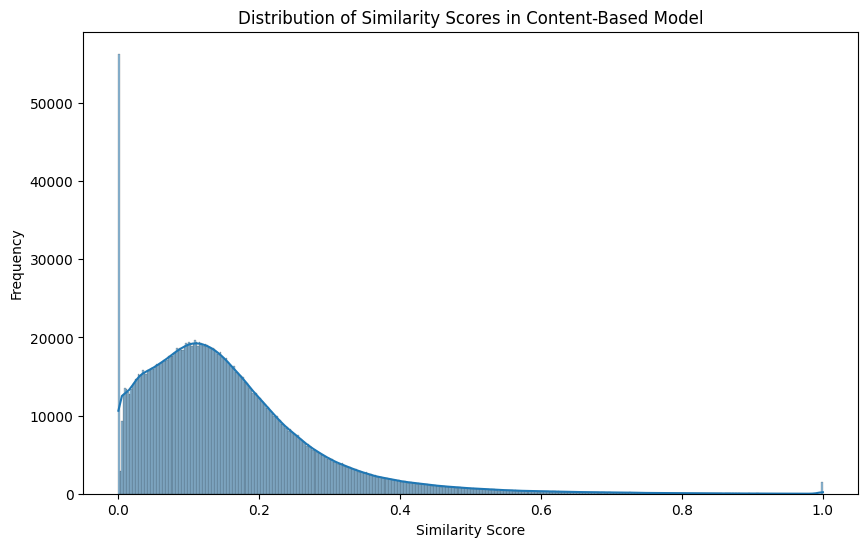

Content-Based Model Evaluation:
Mean similarity score: 0.1562
Median similarity score: 0.1333


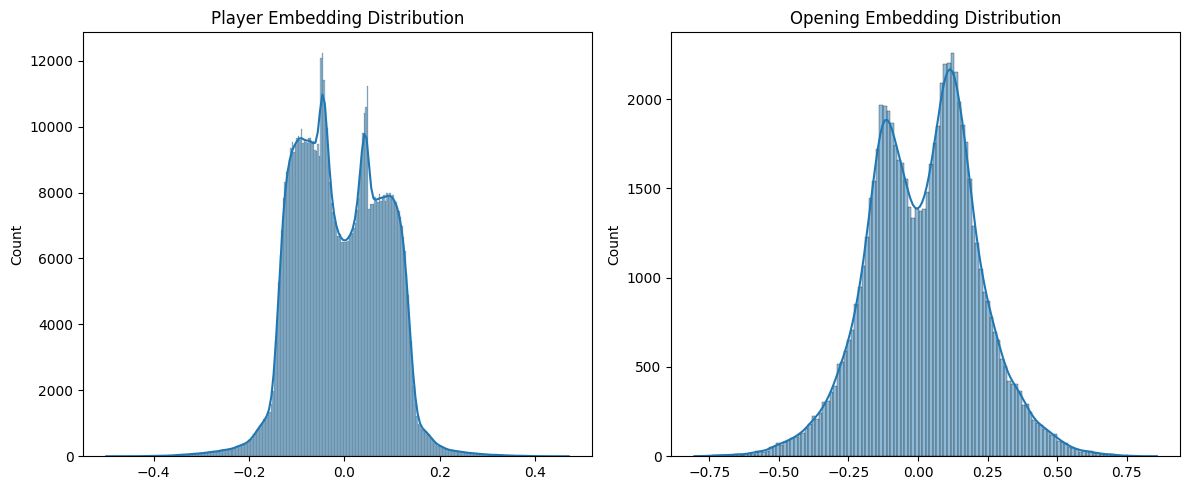


Collaborative Filtering Model Evaluation:
Final training loss: 0.0299
Final validation loss: 0.0758
Final training MAE: 0.1483
Final validation MAE: 0.2367


In [ ]:
print("\nModel Evaluation:")

# Evaluasi Content-Based Model
def evaluate_content_based_model(content_based_model):
    """
    Evaluasi model content-based filtering
    """
    # Cek distribusi similarity scores
    similarity_matrix = content_based_model['similarity_matrix'].values
    plt.figure(figsize=(10, 6))
    sns.histplot(similarity_matrix.flatten(), kde=True)
    plt.title('Distribution of Similarity Scores in Content-Based Model')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.show()

    # Hitung rata-rata similarity score antar opening
    mean_similarity = np.mean(similarity_matrix)
    median_similarity = np.median(similarity_matrix)

    print(f"Content-Based Model Evaluation:")
    print(f"Mean similarity score: {mean_similarity:.4f}")
    print(f"Median similarity score: {median_similarity:.4f}")

# Evaluasi Collaborative Filtering Model
def evaluate_collaborative_model(collaborative_model, history):
    """
    Evaluasi model collaborative filtering
    """
    # Plot distribusi embedding values untuk melihat representasi latent space
    player_embedding = collaborative_model['player_embedding']
    opening_embedding = collaborative_model['opening_embedding']

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(player_embedding.flatten(), kde=True)
    plt.title('Player Embedding Distribution')

    plt.subplot(1, 2, 2)
    sns.histplot(opening_embedding.flatten(), kde=True)
    plt.title('Opening Embedding Distribution')
    plt.tight_layout()
    plt.show()

    # Print training metrics
    final_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_mae = history.history['mean_absolute_error'][-1]
    final_val_mae = history.history['val_mean_absolute_error'][-1]

    print(f"\nCollaborative Filtering Model Evaluation:")
    print(f"Final training loss: {final_loss:.4f}")
    print(f"Final validation loss: {final_val_loss:.4f}")
    print(f"Final training MAE: {final_mae:.4f}")
    print(f"Final validation MAE: {final_val_mae:.4f}")

# Evaluasi model
evaluate_content_based_model(content_based_model)
evaluate_collaborative_model(collaborative_model, history)


# Simpan semua model dan data terkait

In [36]:
print("\nSaving all models and related data...")

# Buat direktori models jika belum ada
if not os.path.exists('models'):
    os.makedirs('models')

# Simpan semua model ke dalam direktori models
import shutil

# Pindahkan file model ke direktori models
if os.path.exists('content_based_model.pkl'):
    shutil.move('content_based_model.pkl', 'models/content_based_model.pkl')

if os.path.exists('collaborative_data.pkl'):
    shutil.move('collaborative_data.pkl', 'models/collaborative_data.pkl')

if os.path.exists('collaborative_model_data.pkl'):
    shutil.move('collaborative_model_data.pkl', 'models/collaborative_model_data.pkl')

if os.path.exists('hybrid_model.pkl'):
    shutil.move('hybrid_model.pkl', 'models/hybrid_model.pkl')

if os.path.exists('collaborative_model.keras'):
    # Untuk TensorFlow SavedModel, pindahkan seluruh direktori
    if os.path.exists('models/collaborative_model'):
        shutil.rmtree('models/collaborative_model')
    shutil.move('collaborative_model.keras', 'models/collaborative_model.keras')

print("All models saved to 'models/' directory")



Saving all models and related data...
All models saved to 'models/' directory


# Tes Load Model

In [34]:
def load_all_models():
    """
    Memuat semua model yang sudah dilatih
    """
    # Load content-based model
    with open('models/content_based_model.pkl', 'rb') as f:
        content_based_model = pickle.load(f)

    # Load collaborative data
    with open('models/collaborative_data.pkl', 'rb') as f:
        collaborative_data = pickle.load(f)

    # Load collaborative model
    collaborative_model = {
        'model': tf.keras.models.load_model('collaborative_model.keras')
    }

    # Load additional collaborative model data
    with open('models/collaborative_model_data.pkl', 'rb') as f:
        collab_data = pickle.load(f)
        collaborative_model.update(collab_data)

    # Load hybrid model
    with open('models/hybrid_model.pkl', 'rb') as f:
        hybrid_model = pickle.load(f)

    return content_based_model, collaborative_data, collaborative_model, hybrid_model

# Coba load model untuk memastikan semua sudah tersimpan dengan benar
try:
    content_based_model, collaborative_data, collaborative_model, hybrid_model = load_all_models()
    print("Successfully loaded all models")
except Exception as e:
    print(f"Error loading models: {e}")

print("\nTraining and evaluation complete!")

Successfully loaded all models

Training and evaluation complete!


# Download models

In [ ]:
# 1. Kompres folder menjadi file ZIP
!zip -r models.zip

# 2. Download file ZIP ke local
from google.colab import files
files.download('models.zip')

  adding: content/models/ (stored 0%)
  adding: content/models/collaborative_data.pkl (deflated 77%)
  adding: content/models/hybrid_model.pkl (deflated 6%)
  adding: content/models/content_based_model.pkl (deflated 10%)
  adding: content/models/collaborative_model.keras (deflated 15%)
  adding: content/models/collaborative_model_data.pkl (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>